In [1]:
import os
import tensorflow
import torch
import torchaudio
import numpy as np
import essentia.standard as es

# Subtask 1: Average Precision

Part 1: Dataset loading. As we will be using torch in Subtask2, we will use its GTZAN loader.

In [2]:
###############################################################################################

# Please first specify the path of your GTZAN dataset if it is already downloaded in your system.
    # Otherwise leave 'data' or the desired path where we will download the dataset.

GTZAN_path = 'data'
#GTZAN_path = <your_path>

###############################################################################################

In [3]:
# Download dataset from torchaudio
if not os.path.isdir(GTZAN_path):
    os.mkdir(GTZAN_path)
    train_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, download=True, subset='training')
else:
    train_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, subset='training')
val_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, subset='validation')
test_dataset = torchaudio.datasets.GTZAN(root=GTZAN_path, subset='testing')

In [4]:
# We download the essentia MSD MusiCNN model
if not os.path.isfile('msd-musicnn-1.pb'):
    !curl -SLO https://essentia.upf.edu/models/autotagging/msd/msd-musicnn-1.pb

In [5]:
# TensorflowPredictMusiCNN expects mono 16kHz sample rate inputs. Resample needed
resample = es.Resample(inputSampleRate=22050, outputSampleRate=16000, quality=0)

In [6]:
# Compute and store the embeddings for each subset
if not os.path.isfile('train_embeddings.npy'):
    train_embeddings = []
    for track in train_dataset:
        train_embeddings.append(es.TensorflowPredictMusiCNN(
            graphFilename='msd-musicnn-1.pb', output='model/dense/BiasAdd')(resample(track[0].numpy()[0])))
    np.save('train_embeddings.npy',np.array(train_embeddings))

    val_embeddings = []
    for track in val_dataset:
        val_embeddings.append(es.TensorflowPredictMusiCNN(
            graphFilename='msd-musicnn-1.pb', output='model/dense/BiasAdd')(resample(track[0].numpy()[0])))
    np.save('val_embeddings.npy',np.array(val_embeddings))

    test_embeddings = []
    for track in test_dataset:
        test_embeddings.append(es.TensorflowPredictMusiCNN(
            graphFilename='msd-musicnn-1.pb', output='model/dense/BiasAdd')(resample(track[0].numpy()[0])))
    test_embeddings=np.array(test_embeddings)
    np.save('test_embeddings.npy',np.array(test_embeddings))
else:
    train_embeddings=np.load('train_embeddings.npy')
    val_embeddings=np.load('val_embeddings.npy')
    test_embeddings=np.load('test_embeddings.npy')

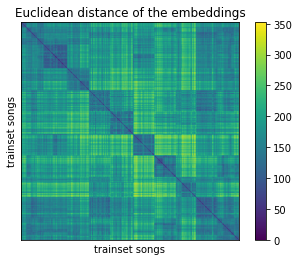

In [7]:
# We compute and visualize the distance of the embeddings between all songs in the training set
emb_distance = np.zeros((len(train_embeddings), len(train_embeddings)))
                        
for indxA, trackA in enumerate(train_embeddings):
    for indxB, trackB in enumerate(train_embeddings):
        emb_distance[indxA, indxB] = np.linalg.norm(trackA - trackB)        

import matplotlib.pyplot as plt
plt.imshow(emb_distance)
plt.colorbar()
plt.xlabel('trainset songs')
plt.ylabel('trainset songs')
plt.xticks([])
plt.yticks([])
plt.title('Euclidean distance of the embeddings');

If we take into account that songs are sorted by genres, from the picture it should be clear that the embedding distance is useful for discerning them.

In [8]:
# Compute Precision@10
precision_at_10 = np.zeros(len(train_embeddings))
for indx in range(len(train_embeddings)): #For each song
    for result_indx in np.argsort(emb_distance[indx, :])[0:10]: #For each of the 10 closest embeddings
        if train_dataset[result_indx][2] == train_dataset[indx][2]: #Check label
            precision_at_10[indx] += 1
    precision_at_10[indx] /= 10.0

In [9]:
#Mean P@10 along the training set:
np.mean(precision_at_10)

0.7846501128668172

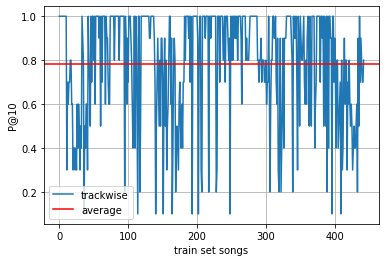

In [10]:
plt.plot(precision_at_10)
plt.xlabel('train set songs')
plt.ylabel('P@10')
plt.grid(True)
plt.axhline(y=np.mean(precision_at_10), color='r')
plt.legend(['trackwise', 'average']);

In [11]:
def MAP(criterion, dataset, at):
    """A function that computes mean average precision of a query of a given length
    on an already computed criterion matrix.

    Parameters:
        criterion: a matrix of NxN with the distance between each element in the dataset
        dataset: a torchaudio.dataset array object of len(dataset)==N
        at: integer corresponding to the number of elements considered in the query.

    References:
        mAP computed as in https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52#1a59
    """
    avgprecision = np.zeros(len(criterion))
    for indx in range(len(criterion)): #For each song
        gtp=0 #total positives
        k=0 #position (relevance)
        for result_indx in np.argsort(criterion[indx, :])[0:at]: ##For each of the "at" closest embeddings
            k+=1
            if train_dataset[result_indx][2] == train_dataset[indx][2]: #Check label
                gtp += 1 #Add to total positives
                avgprecision[indx] += (gtp/k)
        avgprecision[indx] /= gtp
    return np.mean(avgprecision)

In [12]:
#MAP@10
MAP(emb_distance, train_dataset, 10)

0.9197450977297532

In [13]:
#MAP@50
MAP(emb_distance, train_dataset, 50)

0.7638469055158652

# Subtask 2: train a classifier

In [14]:
# Part 1: preparing the data: we combine the GTZAN dataset (we take the labels) with the TF embeddings
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class Essentia_MusiCNNMSD_GTZAN_Dataset(Dataset):
    """ The embeddings of the GTZAN dataset extracted with Essentia-Tensorflow's MusiCNN-MSD model. """
    def __init__(self, GTZAN_dataset, embeddings):
        self.GTZAN_dataset = GTZAN_dataset
        self.embeddings = embeddings
        self.GTZAN_genres = [
            "blues",
            "classical",
            "country",
            "disco",
            "hiphop",
            "jazz",
            "metal",
            "pop",
            "reggae",
            "rock",
        ]
        
    def __len__(self):
        return len(self.GTZAN_dataset)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        inputs = torch.from_numpy(self.embeddings[idx])
        labels = torch.tensor(self.GTZAN_genres.index(self.GTZAN_dataset[idx][2]))
        
        return inputs, labels

In [16]:
embtrain_dataset = Essentia_MusiCNNMSD_GTZAN_Dataset(train_dataset, train_embeddings)
train_loader = torch.utils.data.DataLoader(embtrain_dataset, batch_size=16, shuffle=True, num_workers=4)

embval_dataset = Essentia_MusiCNNMSD_GTZAN_Dataset(val_dataset, val_embeddings)
val_loader = torch.utils.data.DataLoader(embval_dataset, batch_size=16, shuffle=False, num_workers=4)

embtest_dataset = Essentia_MusiCNNMSD_GTZAN_Dataset(test_dataset, test_embeddings)
test_loader = torch.utils.data.DataLoader(embtest_dataset, batch_size=16, shuffle=False, num_workers=4)

In [17]:
# We define a shallow model

class shallowClassifier(nn.Module):
    def __init__(self):
        super(shallowClassifier, self).__init__()
        self.dense1 = nn.Linear(19*200, 100)
        self.dense2 = nn.Linear(100, 10)
        
    def forward(self,x):
        x = x.view(-1, 19*200)
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        
        return x
    
model = shallowClassifier()

In [18]:
if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

num_epochs = 200
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)

bestloss = 100000.0
for epoch in range(num_epochs):
    #The train loop
    model.train()
    for inputs, labels in train_loader:
        # Send data to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # Clear gradient and forward + loss + backward
        optimizer.zero_grad()
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses[epoch] += loss.item()
    train_losses[epoch] /= len(train_loader)
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Send data to the GPU
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs) 
            loss = criterion(outputs, labels)

            val_losses[epoch] += loss.item()
        val_losses[epoch] /= len(val_loader)
        scheduler.step(val_losses[epoch])
        
        # If best epoch, we save parameters
        if val_losses[epoch] < bestloss :
            bestloss = val_losses[epoch]
            torch.save(model.state_dict(), 'model.pth')
    
    print('Epoch '+str(epoch)+': Train Loss = '+str(train_losses[epoch].item())+'. Val Loss = '+str(val_losses[epoch].item())+'.')
print('Best validation loss :' + str(bestloss.item()))

#Finally we load best epoch
model.load_state_dict(torch.load('model.pth'));

Epoch 0: Train Loss = 2.1817314624786377. Val Loss = 2.100552558898926.
Epoch 1: Train Loss = 1.9448091983795166. Val Loss = 1.9094829559326172.
Epoch 2: Train Loss = 1.7528551816940308. Val Loss = 1.7530697584152222.
Epoch 3: Train Loss = 1.598266363143921. Val Loss = 1.6234385967254639.
Epoch 4: Train Loss = 1.4688661098480225. Val Loss = 1.5145764350891113.
Epoch 5: Train Loss = 1.3610296249389648. Val Loss = 1.422865390777588.
Epoch 6: Train Loss = 1.271352767944336. Val Loss = 1.343977689743042.
Epoch 7: Train Loss = 1.1918197870254517. Val Loss = 1.2759939432144165.
Epoch 8: Train Loss = 1.1163790225982666. Val Loss = 1.2171425819396973.
Epoch 9: Train Loss = 1.0573073625564575. Val Loss = 1.1662788391113281.
Epoch 10: Train Loss = 1.003242015838623. Val Loss = 1.121035099029541.
Epoch 11: Train Loss = 0.9547534584999084. Val Loss = 1.0815266370773315.
Epoch 12: Train Loss = 0.9104846119880676. Val Loss = 1.0471338033676147.
Epoch 13: Train Loss = 0.8725343942642212. Val Loss = 1

Epoch 111: Train Loss = 0.2537788152694702. Val Loss = 0.6702967286109924.
Epoch 112: Train Loss = 0.24832503497600555. Val Loss = 0.6704149842262268.
Epoch 113: Train Loss = 0.24984288215637207. Val Loss = 0.6700228452682495.
Epoch 114: Train Loss = 0.24585512280464172. Val Loss = 0.6697064638137817.
Epoch 115: Train Loss = 0.24475710093975067. Val Loss = 0.6694166660308838.
Epoch 116: Train Loss = 0.2436324656009674. Val Loss = 0.6696443557739258.
Epoch 117: Train Loss = 0.24274039268493652. Val Loss = 0.669697642326355.
Epoch 118: Train Loss = 0.2413710504770279. Val Loss = 0.6699646711349487.
Epoch 119: Train Loss = 0.2402121126651764. Val Loss = 0.6704257726669312.
Epoch 120: Train Loss = 0.23952975869178772. Val Loss = 0.6708291172981262.
Epoch 121: Train Loss = 0.23639413714408875. Val Loss = 0.6705337166786194.
Epoch 122: Train Loss = 0.23465800285339355. Val Loss = 0.6701568961143494.
Epoch 123: Train Loss = 0.2359081655740738. Val Loss = 0.6698411107063293.
Epoch 124: Train L

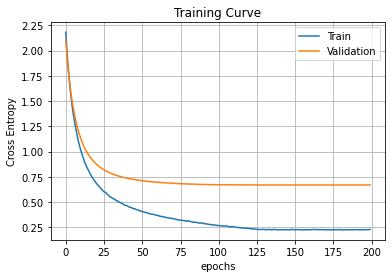

In [19]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('Cross Entropy')
plt.title('Training Curve');

In [20]:
# Finally we compute accuracy with the test set
model.eval()
confusion_matrix = torch.zeros(len(embtrain_dataset.GTZAN_genres), len(embtrain_dataset.GTZAN_genres))
with torch.no_grad():
    for inputs, labels in test_loader:
        # Send data to the GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

In [21]:
# Per-class Accuracy
pclass_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
print('Per-class Accuracy:\n')
for classes, pclass_accs in zip(embtrain_dataset.GTZAN_genres, pclass_acc):
    print(classes +': ' +str(round(pclass_accs.item(),2)))

Per-class Accuracy:

blues: 0.77
classical: 1.0
country: 0.83
disco: 0.9
hiphop: 0.85
jazz: 0.89
metal: 0.81
pop: 0.77
reggae: 0.62
rock: 0.66


In [22]:
print('   ------------------>Actual ------>')
print(confusion_matrix.numpy())

   ------------------>Actual ------>
[[24.  0.  0.  0.  0.  3.  0.  0.  3.  1.]
 [ 0. 31.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1. 25.  0.  0.  0.  0.  1.  1.  1.]
 [ 1.  0.  0. 26.  0.  0.  0.  0.  2.  0.]
 [ 1.  0.  0.  0. 23.  0.  0.  0.  3.  0.]
 [ 0.  3.  0.  0.  0. 24.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 22.  0.  0.  5.]
 [ 0.  0.  0.  2.  4.  0.  0. 23.  0.  1.]
 [ 1.  0.  0.  1.  6.  1.  0.  0. 16.  1.]
 [ 4.  0.  0.  2.  2.  0.  1.  1.  1. 21.]]
